In [1]:
import plotly.express as px
import sklearn as sk
import pandas as pd
import numpy as np
import random


In [37]:
actions_data = pd.read_csv("../data/new_actions.csv").dropna().astype(int)
cars_data = pd.read_csv("../data/cars_about.csv").dropna()

In [38]:
actions_data

,car_id,user_id
0,211,0
1,59,0
2,7,0
3,0,0
4,5,0
...,...,...
567,12,74
568,6,74
569,11,74
570,10,74


In [31]:
data.to_csv("../data/dataset.csv", index=False)

In [6]:
cars_data

,car_id,car_model,used_label,price,exteriorColor,interiorColor,drivetrain,minMPG,maxMPG,fuelType,transmission,engine,mileage
0,1.0,Toyota Sienna SE,Used,$39,Red,Black,Front-wheel Drive,19.0,27.0,Gasoline,8-Speed Automatic,3.5L V6 24V PDI DOHC,29403.0
1,2.0,Ford F-150 Lariat,Used,$49,Shadow Black,Black,Four-wheel Drive,19.0,24.0,Gasoline,10-Speed Automatic,3.5L V6 24V PDI DOHC Twin Turbo,32929.0
2,3.0,RAM 1500 Laramie,Used,$41,Granite Crystal Clearcoat Metallic,Black,Four-wheel Drive,15.0,21.0,Gasoline,8-Speed Automatic,5.7L V8 16V MPFI OHV,23173.0
3,4.0,Honda Accord Sport SE,Used,$28,Gray,–,Front-wheel Drive,29.0,35.0,Gasoline,Automatic CVT,1.5L I4 16V GDI DOHC Turbo,10598.0
4,5.0,Lexus RX 350,Used,$49,Eminent White Pearl,Birch,Front-wheel Drive,20.0,27.0,Gasoline,8-Speed Automatic,3.5L V6 24V PDI DOHC,28137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,401.0,Jeep Grand Cherokee Limited,Used,$33,Diamond Black,Black,Four-wheel Drive,18.0,25.0,Gasoline,8-Speed Automatic,3.6L V6 24V MPFI DOHC,43807.0
400,402.0,Toyota RAV4 Hybrid XLE,Toyota Certified,$30,Super White,Nutmeg,All-wheel Drive,34.0,30.0,Hybrid,Automatic CVT,2.5L I4 16V MPFI DOHC Hybrid,41944.0
401,403.0,Cadillac XT4 Sport,Used,$35,Black,Black,All-wheel Drive,22.0,29.0,Gasoline,9-Speed Automatic,2.0L I4 16V GDI DOHC Turbo,49386.0
402,404.0,Chevrolet Tahoe LTZ,Used,$35,Tungsten Metallic,Jet Black,Four-wheel Drive,16.0,22.0,Gasoline,6-Speed Automatic,5.3L V8 16V GDI OHV,115795.0


In [7]:
actions_data

,car_id,user_id
0,84,0
1,171,0
2,80,0
3,126,0
4,184,0
...,...,...
2869,13,74
2870,17,74
2871,17,74
2872,16,74


In [8]:
actions_data = actions_data.astype(int)

In [9]:
user_data = pd.DataFrame(
    columns = sorted(actions_data.car_id.unique(), key=int), 
    index=actions_data.user_id.unique()
    )
user_data

,0,1,2,3,4,5,6,7,8,9,...,268,279,284,293,298,305,307,335,336,359
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


У меня есть действия пользователей в которые входит только информация о том лайкнул он авто или нет, мне кажется, что это довольно скупая информация. Для того чтобы диверсифицировать предпочтения сгенерированных пользователей я буду рандомно генерировать рейтинги для фильмов <br> Каким образом? <br> авто было добавлено в любимые? => random([3, 4, 5]) <br> С остальными авто поступаю иначе, генерирую для пользователя рандомное кол-во авто с низким рейтингом и уже эти авто раздаю рейтинги от 1-2

In [10]:
for user_id in actions_data.user_id:
    current_user_actions = actions_data.query(f"user_id == {user_id}")
    for car_id in current_user_actions.car_id:
        user_data[int(car_id)].iloc[user_id] = 1#random.randint(4, 5) 

user_data

,0,1,2,3,4,5,6,7,8,9,...,268,279,284,293,298,305,307,335,336,359
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,NaN,1,1,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,NaN,1,1,1,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
user_data.transpose()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1
4,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
335,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
336,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# num_unique_cars = len(user_data.columns)

# for row_idx in user_data.index:
#     # specify the number of NaN values to replace with random numbers
#     # from 0 to number of non-defined cars
#     n = random.randint(0, num_unique_cars - user_data.iloc[row_idx].notna().sum())
#     # get the columns with NaN values in the specified row
#     cols_with_nans =  user_data.iloc[row_idx][ user_data.iloc[row_idx].isnull()].index.tolist()

#     # randomly fill 'n' of the NaN values in the specified row with values between 0 and 10
#     random_values = np.random.randint(1, 3, n)
#     for col in np.random.choice(cols_with_nans, n, replace=False):
#         user_data.loc[row_idx, col] = random_values[n - 1]

In [13]:
user_data

,0,1,2,3,4,5,6,7,8,9,...,268,279,284,293,298,305,307,335,336,359
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,NaN,1,1,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,NaN,1,1,1,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
user_data.to_csv("../data/user_data.csv", index=False)

In [15]:
matrix = user_data.div(user_data.sum(axis=1), axis=0)
# matrix = user_data

In [16]:
matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,268,279,284,293,298,305,307,335,336,359
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.166667,NaN,NaN,NaN,0.166667,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.166667,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,NaN
4,0.055556,0.055556,NaN,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.055556,NaN


In [17]:
users_pierson_correlation = matrix.fillna(0).T.corr()

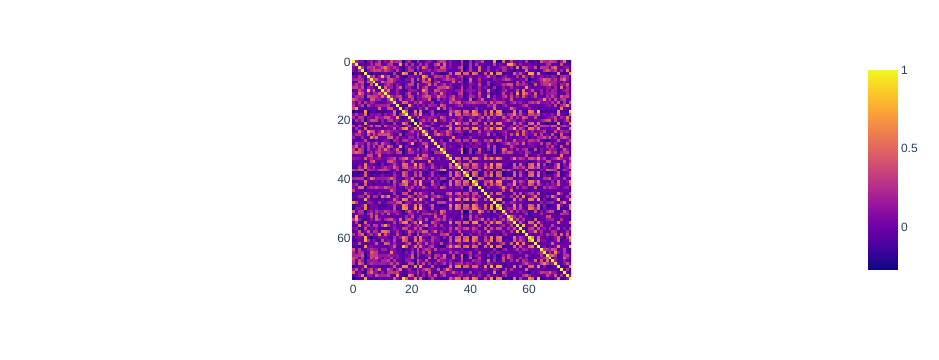

In [18]:
fig = px.imshow(users_pierson_correlation)
fig.show()

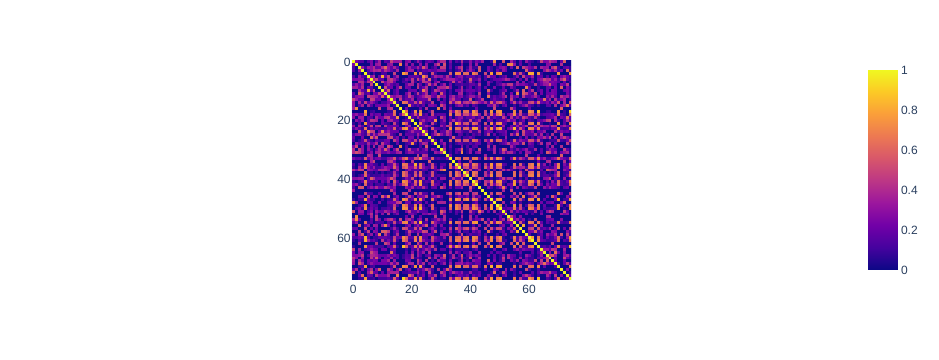

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

user_cosine_similarity = cosine_similarity(matrix.fillna(0))
px.imshow(user_cosine_similarity)

In [20]:
picked_user_id = 1
users_pierson_correlation.drop(index= picked_user_id, inplace=True)
users_pierson_correlation.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,1.000000,0.208549,0.051878,0.051878,-0.207670,0.051878,0.154762,-0.087070,0.076013,0.299302,...,0.208549,0.180986,0.372166,0.299302,0.250108,-0.176604,0.146578,0.532310,-0.087070,-0.230940
2,0.051878,-0.051726,1.000000,0.271795,-0.060659,0.271795,0.212022,0.364991,0.114286,0.145378,...,0.254320,0.239237,-0.092308,0.364991,0.510108,-0.023303,-0.063815,0.089744,0.145378,-0.085948
3,0.051878,-0.051726,0.271795,1.000000,-0.177059,0.089744,0.212022,0.364991,0.312197,0.364991,...,0.254320,0.409096,0.271795,0.145378,0.312197,-0.023303,0.187901,-0.092308,0.584604,-0.085948
4,-0.207670,-0.099218,-0.060659,-0.177059,1.000000,-0.060659,-0.207670,-0.001978,-0.160403,-0.142394,...,-0.099218,-0.192734,-0.177059,-0.142394,-0.160403,0.687663,-0.122407,-0.177059,-0.142394,0.686417
5,0.051878,-0.051726,0.271795,0.089744,-0.060659,1.000000,0.212022,0.364991,-0.083624,0.145378,...,-0.051726,0.069379,-0.092308,0.145378,0.114286,-0.150572,0.187901,0.271795,0.145378,-0.085948


In [21]:
top_n_users = 10
user_similarity_threshold = 0.3
similar_users = users_pierson_correlation[users_pierson_correlation[picked_user_id] > user_similarity_threshold]

In [22]:
similar_users

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
9,0.299302,0.327592,0.145378,0.364991,-0.142394,0.145378,0.106116,-0.059701,-0.067252,1.000000,...,-0.041599,0.124097,0.145378,-0.059701,0.171493,-0.121093,0.555982,-0.074235,0.205224,-0.024507
16,0.335410,0.702038,-0.036314,-0.036314,-0.069655,-0.036314,-0.042592,-0.029204,-0.032898,0.489168,...,-0.020349,-0.039528,-0.036314,-0.029204,-0.032898,-0.059235,0.569043,-0.036314,-0.029204,-0.077460
29,0.208549,0.485507,-0.051726,0.254320,-0.099218,0.254320,-0.060669,0.327592,-0.046860,0.327592,...,-0.028986,0.229243,-0.051726,0.327592,-0.046860,-0.084376,0.387399,-0.051726,-0.041599,-0.110335
31,0.330404,0.514792,0.409096,0.239237,-0.192734,0.069379,0.180986,-0.080807,0.278284,0.329002,...,-0.056305,0.524554,0.409096,0.124097,0.278284,-0.163903,0.165393,0.239237,0.329002,-0.110810
48,0.685674,0.327592,-0.074235,-0.074235,-0.142394,0.145378,0.106116,-0.059701,-0.067252,0.205224,...,-0.041599,0.124097,0.145378,0.205224,-0.067252,-0.121093,0.252330,0.584604,-0.059701,-0.158350
53,-0.042592,0.702038,-0.036314,-0.036314,-0.069655,-0.036314,0.335410,-0.029204,0.434248,-0.029204,...,-0.020349,0.361403,0.393398,-0.029204,-0.032898,-0.059235,-0.025105,-0.036314,-0.029204,-0.077460
54,0.299302,0.696784,0.145378,-0.074235,-0.142394,-0.074235,0.106116,-0.059701,0.410238,0.205224,...,-0.041599,0.124097,0.145378,0.205224,-0.067252,-0.121093,0.252330,-0.074235,-0.059701,-0.158350
71,0.146578,0.387399,-0.063815,0.187901,-0.122407,0.187901,0.368003,-0.051321,0.215832,0.555982,...,-0.035760,-0.069465,-0.063815,-0.051321,-0.057812,-0.104096,1.000000,-0.063815,0.252330,-0.136123


In [23]:
# Movies that the target user has watched
picked_userid_watched = matrix[matrix.index == picked_user_id].dropna(axis=1, how='all')
picked_userid_watched

,125,135
1,0.5,0.5


In [24]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix[matrix.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

,60,65,84,92,125,126,135,142,171,184,219,279,293,335,359
9,NaN,0.25,0.25,NaN,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN,NaN
16,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,NaN,NaN,NaN,NaN,0.5,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,0.142857,NaN,NaN,NaN,0.142857,NaN,0.142857,NaN,NaN,0.142857,0.142857,0.142857,0.142857,NaN,NaN
48,NaN,NaN,NaN,NaN,0.25,0.25,NaN,NaN,0.25,0.25,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,NaN,NaN,NaN,NaN,0.25,NaN,0.25,NaN,NaN,NaN,NaN,NaN,NaN,0.25,0.25
71,NaN,0.333333,NaN,0.333333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
# Take a look at the data
similar_user_movies

,60,65,84,92,126,142,171,184,219,279,293,335,359
9,NaN,0.25,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,0.142857,0.142857,0.142857,0.142857,NaN,NaN
48,NaN,NaN,NaN,NaN,0.25,NaN,0.25,0.25,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,0.25
71,NaN,0.333333,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# A dictionary to store item scores
item_score = {}
# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count
# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)
# Select top m movies
m = 10
ranked_item_score.head(m)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
cars_data.loc[cars_data.car_id.isin(ranked_item_score.movie) == True]

,car_id,car_model,used_label,price,exteriorColor,interiorColor,drivetrain,minMPG,maxMPG,fuelType,transmission,engine,mileage
58,60.0,Land Rover Range Rover,Used,$51,Santorini Black,Ebony / Ebony,Four-wheel Drive,14.0,19.0,Gasoline,8-Speed Automatic,5.0L V8 32V GDI DOHC Supercharged,54449.0
63,65.0,Chrysler 300 S,Used,$33,Granite Crystal Clearcoat Metallic,Linen,Rear-wheel Drive,19.0,30.0,Gasoline,8-Speed Automatic,5.7L V8 16V MPFI OHV,27054.0
82,84.0,Mercedes-Benz S-Class S 560 4MATIC,Used,$62,Black,White,All-wheel Drive,17.0,27.0,Gasoline,9-Speed Automatic,4.0L V8 32V GDI DOHC Twin Turbo,35652.0
90,92.0,Toyota Camry SE,Used,$31,Black,Black,Front-wheel Drive,28.0,39.0,Gasoline,8-Speed Automatic,2.5L I4 16V PDI DOHC,27521.0
124,126.0,Buick Enclave Essence,Used,$36,Satin Steel Metallic,Dark Galvanized,Front-wheel Drive,18.0,26.0,Gasoline,9-Speed Automatic,3.6L V6 24V GDI DOHC,29500.0
140,142.0,INFINITI QX60 Pure,Used,$31,Black Obsidian,Graphite,Front-wheel Drive,20.0,27.0,Gasoline,Automatic CVT,3.5L V6 24V GDI DOHC,48522.0
169,171.0,Acura MDX 3.5L w/Technology Package,Used,$39,Gray,Espresso,All-wheel Drive,19.0,26.0,Gasoline,9-Speed Automatic,3.5L V6 24V GDI SOHC,12304.0
182,184.0,Toyota Corolla SE,Used,$18,Blue,Black,Front-wheel Drive,31.0,40.0,Gasoline,Automatic CVT,2.0L I4 16V PDI DOHC,10514.0
217,219.0,Mercedes-Benz S-Class S 550 4MATIC,Used,$15,Blue,Brown,All-wheel Drive,14.0,20.0,Gasoline,7-Speed Automatic,5.5L V8 32V MPFI DOHC,89247.0
277,279.0,Mazda CX-5 Grand Touring,Used,$27,Jet Black Mica,Parchment,Front-wheel Drive,25.0,31.0,Gasoline,6-Speed Automatic,2.5L I4 16V GDI DOHC,37852.0
